# Modelling polydeformation

### Import the Forward Modelling Engine modules - LoopStructural

In [1]:
#import the Forward Modelling Engine modules - LoopStructural
from LoopStructural.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
from LoopStructural.interpolators.discrete_fold_interpolator import DiscreteFoldInterpolator as DFI
from LoopStructural.modelling.features.geological_feature import GeologicalFeatureInterpolator
from LoopStructural.modelling.structural_frame import StructuralFrameBuilder
from LoopStructural.modelling.fold.foldframe import FoldFrame
from LoopStructural.modelling.fold.fold import FoldEvent
from LoopStructural.modelling.fold.svariogram import SVariogram
from LoopStructural.modelling.fold.fold_rotation_angle_feature import FoldRotationAngleFeature, fourier_series
from LoopStructural.supports.tet_mesh import TetMesh
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation.rotation_angle_plotter import RotationAnglePlotter

# import other libraries
import pandas as pd
import numpy as np
import glob
import os
from scipy.interpolate import Rbf
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

### Load data from csv files
Use glob to find all csvs in directory and then import into a dictionary of pandas data frames

In [2]:
data ={}
for f in glob.glob('data/noddy_synth/*.csv'):
    data[os.path.basename(f)] = np.loadtxt(f,delimiter=" ")
    
origin = (0,0,0)
maximum = (10000,10000,5000)

### Building the Mesh
Build a mesh that covers at least the area of interest. In this case use the origin and maximum extent. Define the number of tetras - start with a moderate number 50k and work upwards when the model is working.

In [3]:
boundary_points = np.zeros((2,3))
buffer = 200 # make the mesh bigger than the model area
boundary_points[0,0] = origin[0] 
boundary_points[0,1] = origin[1] 
boundary_points[0,2] = origin[2]
boundary_points[1,0] = maximum[0]
boundary_points[1,1] = maximum[1]
boundary_points[1,2] = maximum[2]
boundary_points[0,:] -= buffer
boundary_points[1,:] += buffer
mesh = TetMesh()
mesh.setup_mesh(boundary_points, n_tetra=5000,)

boundary_points[0,:] += buffer
boundary_points[1,:] -= buffer

### Building the Fold Frame F2

Associate the different coordinates of the fold frame with the data that defines their geometry.

* coordinate 0 is associated with the axial foliation
* coordinate 1 is associated with the fold axis direction which is either an observation of the fold axis or can be defined as the strike rotated by 90

In [4]:
#print(data['s2_dir.csv'])
fold_frame2_interpolator = PLI(mesh)
fold_frame2_builder = StructuralFrameBuilder(
    interpolator=fold_frame2_interpolator,
    mesh=mesh,
    name='F2_fold_frame')
# Interfacing with dataframes should be done using a convenience wrapper function
for r in data['s2_dir.csv']:
    if r[3] < -10:
        continue
    fold_frame2_builder.add_planar_constraint(r[0:3],-r[3:],itype='gx')
    fold_frame2_builder.add_planar_constraint(r[0:3],[r[4],r[3],r[5]],itype='gy')

r = data['s2_val.csv']
fold_frame2_builder.add_point(r[0:3],r[3],itype='gx')
fold_frame2_builder.add_point(r[0:3],r[3],itype='gy')

Run interpolation with default parameters using lu solver. When building a fold frame, which is a type of structural frame it is important to pass the `kwarg=FoldFrame` so that the builder knows to build a fold frame not a base StructuralFrame.

In [5]:
f2_frame = fold_frame2_builder.build(
    frame=FoldFrame,
    solver='lu',
)

Resetting interpolation constraints
Resetting interpolation constraints
Resetting interpolation constraints
Building structural frame coordinate 0
Building structural frame coordinate 1
Creating analytical structural frame coordinate 2


Now we can visualize the fold frame isosurfaces with Lavavu

Creating isosurface for -6264.907871
Creating isosurface for 2744.757112



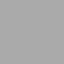

In [6]:
viewer = LavaVuModelViewer(background="white")
viewer.plot_model_box(boundary_points,
                      (100,100,50),
                      's2',
                      paint_with=f2_frame.features[0],
                     cmap='jet')
viewer.plot_isosurface(f2_frame.features[0],  colour='green')
viewer.plot_isosurface(f2_frame.features[1],  colour='blue')
viewer.plot_data(f2_frame.features[0])
viewer.interactive()

#### Create a fold linked to the fold frame<br>
We need to create a fold event that links our fold frame to the fold event so that it can given to the fold interpolator.

In [7]:
fold = FoldEvent(f2_frame,None,None)

## Build F1 Fold frame
### Using fold interpolator
The DiscreteFoldInterpolator is a PiecewiseLinearInterpolator that adds additional constraints to the interpolation process using the geometry of the fold. It can be initialised using a fold and mesh. 

In [8]:
f1_fold_interpolator = DFI(mesh,fold)

### Link data and initialise interpolators
Create a fold frame object using a base PLI interpolator as that is what will be used for the 2nd and 3rd coordinates of the fold frame. 
Update the interpolator to a fold interpolator by accessing the interpolator and update the property name for this interpolator:
```Python
fold_frame1_builder.interpolators[0] = f1_fold_interpolator
fold_frame1_builder.interpolators[0].set_property_name(fold_frame1_builder.name+'_gx')
```
Follow the standard procedure for associating data with the interpolator. 



In [9]:
#print(data['s2_dir.csv'])
fold_frame1_interpolator = PLI(mesh)
fold_frame1_builder = StructuralFrameBuilder(
    interpolator=fold_frame1_interpolator,
    mesh=mesh,
    name='F1_fold_frame')
# update the coordinate 0 interpolator to be a fold interpolator
fold_frame1_builder.interpolators[0] = f1_fold_interpolator
fold_frame1_builder.interpolators[0].set_property_name(fold_frame1_builder.name+'_gx')
for r in data['s1_dir.csv']:
    if r[3] < -10:
        continue
    fold_frame1_builder.add_planar_constraint(r[0:3],r[3:],itype='gx')

# because type 3 interference the gy can be the same for different folds.
for r in data['s2_dir.csv']:
    if r[3] < -10:
        continue
#     fold_frame2_builder.add_planar_constraint(r[0:3],-r[3:],itype='gx')
    fold_frame1_builder.add_planar_constraint(r[0:3],[r[4],r[3],r[5]],itype='gy')
    
for r in data['s1_val.csv']:
    fold_frame1_builder.add_point(r[0:3],r[3],itype='gx')
r = data['s2_val.csv']
# fold_frame1_builder.add_point(r[0:3],r[3],itype='gx')
fold_frame1_builder.add_point(r[0:3],r[3],itype='gy')

### Creating S-Plot and S-Variograms
The S-Plot is a cross plot of the fold rotation angle and the fold frame coordinate, the S-Variogram is an experimental semi-variogram calculated using the fold frame coordinate. To create both of these plots calculate both of these we need to first initialise the interpolators by calling build without a solver.
```Python
fold_frame1_builder.build(solver=None)
```
#### Calculating the fold axis rotation angle
This makes the builder link the data to the interpolator object.

The first step is to calculate the fold axis rotation angle, which calculates the intersection lineation between the first coordinate of the fold frame (the axial foliation field) and the folded foliation and then the angle between this lineation and the gradient of the second coordinate of the fold frame.
```Python
far = f2_frame.calculate_fold_axis_rotation(
    fold_frame1_builder.interpolators[0].get_gradient_control())
```
The value of the second coordinate of the fold frame can then be calculated by evaluating the value for all of the locations of the intersection lineation.

```Python
s2gy = f2_frame.features[1].evaluate_value(
    fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3])
```
A SVariogram can then be calculated for these values
```Python
axis_svariogram = SVariogram(s2gy,far)
```
The SVariogram can be run by calling `calc_semivariogram()` or by specifying some kwargs:

* step and nstep - size of semi-variogram lag and number of lags
* lag array of lags

Another useful tool is to calculate the intesection lineation for visualisation of the model results. 
```Python
l2 = l2 = f2_frame.calculate_intersection_lineation(
    fold_frame1_builder.interpolators[0].get_gradient_control())
```


In [10]:
fold_frame1_builder.build(solver=None) # fake build to get data in right form
far = f2_frame.calculate_fold_axis_rotation(
    fold_frame1_builder.interpolators[0].get_gradient_control())
s2gy = f2_frame.features[1].evaluate_value(
    fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3])
axis_svariogram = SVariogram(s2gy,far)
lags, variogram, npairs = axis_svariogram.calc_semivariogram()
# optionally calculate the intersection lineation for visualisation
l2 = f2_frame.calculate_intersection_lineation(
    fold_frame1_builder.interpolators[0].get_gradient_control())

Resetting interpolation constraints
Resetting interpolation constraints
Resetting interpolation constraints
Building structural frame coordinate 0
Cannot rerun interpolator
Building structural frame coordinate 1
Cannot rerun interpolator
Creating analytical structural frame coordinate 2


These can be plotted using matplotlib, in this example the number of pairs is plotted semi-transparently on a separate axis to the semi-variogram. For more information on how to customise the matplotlib plot layouts see the matploblib documentation 

(-90, 90)

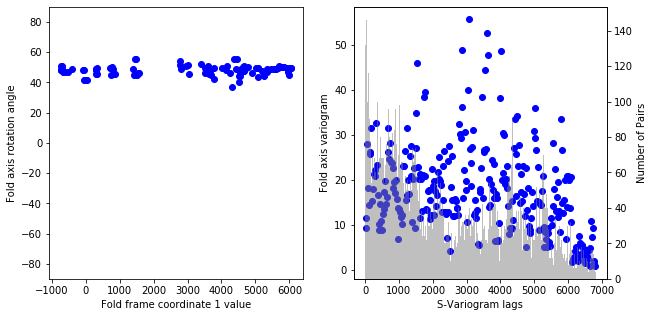

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
ax[0].plot(s2gy,far,'bo')
ax[0].set_ylabel('Fold axis rotation angle')
ax[0].set_xlabel('Fold frame coordinate 1 value')

npairsax = ax[1].twinx()
npairsax.bar(lags,npairs,lags[1]-lags[0],color='grey',alpha=0.5)
npairsax.set_ylabel('Number of Pairs')

ax[1].plot(lags,variogram,'bo')
ax[1].set_ylabel('Fold axis variogram')
ax[1].set_xlabel('S-Variogram lags')


ax[0].set_ylim(-90,90)

There are two options for specifying the fold axis for the model:

1. Specify the fold axis as a constant vector
2. Specifying the fold axis as a rotation of the second coordinate of the fold frame. 

Looking at the S-Plot above it is clear that the fold axis is constant in this example. The easiest option is to just use the average of the intersection lineation.

The fold object needs to be updated with either a fold_axis_rotation angle or a fold_axis:
```Python
fold.fold_axis = np.array([vx,vy,vz])
fold.fold_axis_rotation = f(x)
```

In this case the fold axis will be set to the average of the l2 intersection lineation.

In [12]:
fold.fold_axis = np.mean(l2,axis=0)
print(fold.fold_axis)

[-0.01416774  0.71194606 -0.70001351]


#### Calculating the fold limb rotation angle
To calculate the fold limb rotation angle the fold axis must be evaluated for all of the locations of the data points. 
```Python
axis = fold.get_fold_axis_orientation(
    fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3])
``` 
This returns an Nx3 numpy array for the fold axis at all of the locations. 
The fold limb rotation angle can then be calculated by calling:
```Python
flr = f2_frame.calculate_fold_limb_rotation(
    fold_frame1_builder.interpolators[0].get_gradient_control(),axis=axis)
```
Where the first argument is a Nx6 array of locations and orientation vectors. The axis argument is optional (and in this case not necessary) but provides a fold axis for the vectors to be projected on before the angle is calculated. This becomes more important when using more complicated models.  

In [13]:
axis = fold.get_fold_axis_orientation(
    fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3])
flr = f2_frame.calculate_fold_limb_rotation(
    fold_frame1_builder.interpolators[0].get_gradient_control(),axis=axis)

s2 = f2_frame.features[0].evaluate_value(
    fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3])


limb_svariogram = SVariogram(s2,flr)

lags, variogram, npairs = limb_svariogram.calc_semivariogram()


Plotting as for the fold axis rotation angle

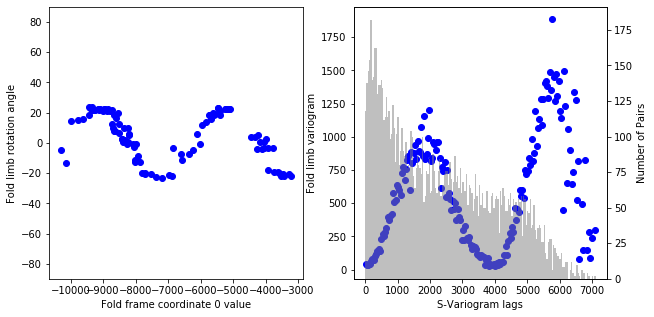

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
ax[0].plot(s2,flr,'bo')
ax[0].set_ylabel('Fold limb rotation angle')
ax[0].set_xlabel('Fold frame coordinate 0 value')

npairsax = ax[1].twinx()
npairsax.bar(lags,npairs,lags[1]-lags[0],color='grey',alpha=0.5)
npairsax.set_ylabel('Number of Pairs')

ax[1].plot(lags,variogram,'bo')
ax[1].set_ylabel('Fold limb variogram')
ax[1].set_xlabel('S-Variogram lags')


t = ax[0].set_ylim(-90,90)

In this example the fold rotation angle appears to be periodic. A clear peak can be seen in the S-Variogram at ~2000m. The hole at 4000m suggests that the wavelength of the data in the S-Plot is 4000m. 

This type of profile indicates that a simple sine wave or low complexity Fourier series can be used to represent this dataset as for these observations the data is periodic. 

#### Fitting the fold rotation angle
A Fourier series is preferable as it has some flexibility in the shape of the curve between periods. The basic form of a Fourier series is:
\begin{equation}
f(x) = a_0 + \sum_{k=1}^N \left( A_k cos(\frac{k\pi x}{\lambda}) + B_k sin(\frac{k\pi x}{\lambda}) \right)
\end{equation}
Where N is the number of terms in the Fourier series. 
For $N = 1$ the Fourier series can be implemented as a numpy function.

```Python
def fourier_series(x,c0,c1,c2,w):
    v = np.array(x.astype(float))
    v.fill(c0)
    v = c0 + c1*np.cos(2*np.pi/w*x) + c2*np.sin(2*np.pi/w*x)
    return np.rad2deg(np.arctan(v))
```
Rather than fitting the fold rotation angles directly the fourier series should be fit to the gradient of the fold shape which can be calculated by finding the tangent of the fold rotation angle.

We use scipy optimise to fit the three Fourier coefficients c0,c1,c2 and the wavelength w. Because we want to fit the wavelength and coefficients simultaneously it is necessary to use a non-linear solver. Therefore initial estimates of the parameter values are necessary to help the optimizer converge. 

In this case the Fourier coefficients can be initialised at 0.0 and the wavelength estimated from the S-Variogram at 4000.

Once the fourier series has been fitted this can be wrapped inside a fold rotation angle function and linked to the fold.
```Python
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))
fold.fold_limb_rotation = fold_limb_rotation
```

For visualisation it is also possible to create a geological feature that is the fold rotation angle.

```Python
fold_rotation_feature = fold_rotation_angle_feature(fold_frame,fold_rotation)
```

In [15]:
wavelength_guess = 4000
flr_tan = np.tan(np.deg2rad(flr))

guess = np.zeros(4)
guess[3] = wavelength_guess

popt, pcov = curve_fit(fourier_series,s2,flr_tan,guess)
xi = np.linspace(f2_frame.features[0].min(),f2_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))
# flr_feature = fold_rotation_angle_feature(f2_frame,fold_limb_rotation)
fold.fold_limb_rotation = fold_limb_rotation

#### RotationAnglePlotter
The S-Plots and S-Variograms can also be produced using the RotationAnglePlotter class.

Text(0.5, 1.0, 'Fold axis rotation angle S-Variogram')

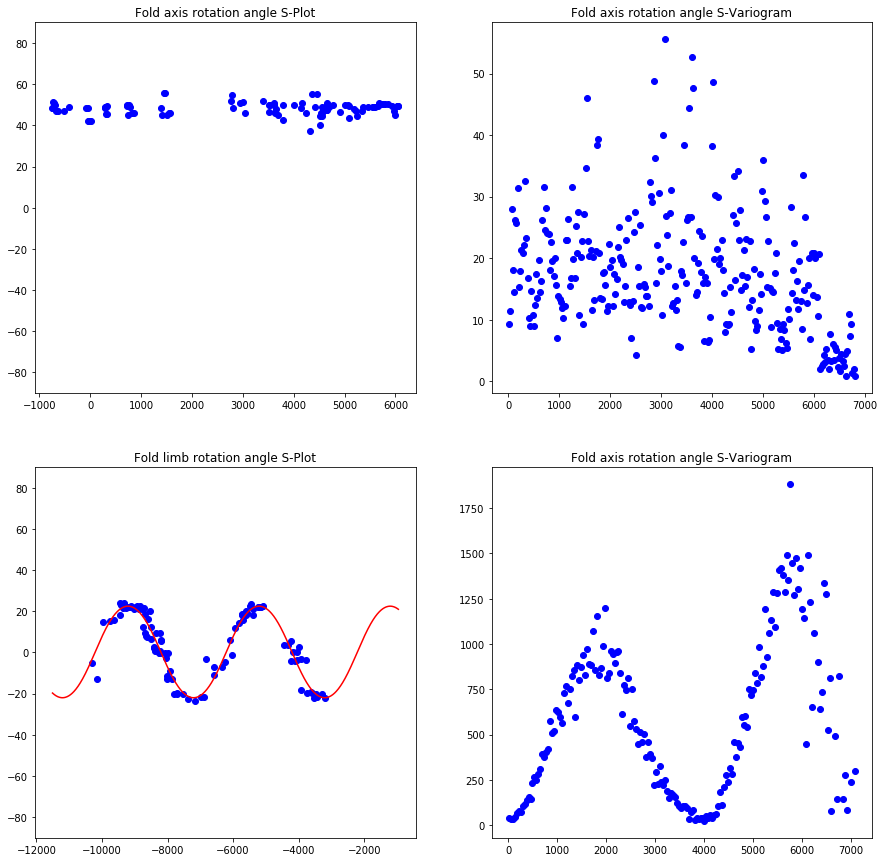

In [16]:
rotation_plots = RotationAnglePlotter()
rotation_plots.add_fold_axis_data(far,s2gy)
rotation_plots.add_axis_svariogram(axis_svariogram)
# rotation_plots.add_fold_axis_curve(fold.fold_axis_rotation(xi),xi)
rotation_plots.add_fold_limb_data(flr,s2)
rotation_plots.add_limb_svariogram(limb_svariogram)
rotation_plots.add_fold_limb_curve(fold.fold_limb_rotation(xi), xi)
rotation_plots.ax[0][0].set_title("Fold axis rotation angle S-Plot")
rotation_plots.ax[0][1].set_title("Fold axis rotation angle S-Variogram")
rotation_plots.ax[1][0].set_title("Fold limb rotation angle S-Plot")
rotation_plots.ax[1][1].set_title("Fold axis rotation angle S-Variogram")

### Adding fold constraints to the interpolator
Once the fold has been assigned a fold axis and fold limb rotation angle the interpolator can be run. There are four different weights that can be applied to the fold interpolator.
These weights can be specified by a dictionary and then passed to the fold_frame_builder. When building a folded surface you must pass the kwargs `fold_weights` and `fold` otherwise only standard inteprolation will be performed. As for the F2 frame make sure that the `frame=FoldFrame` is passed as we want to build a fold frame not a basic StructuralFrame

In [17]:
fold_weights = {}
fold_weights['fold_orientation'] = 10. # reference values?
fold_weights['fold_axis'] = 10. # reference values?
fold_weights['fold_normalisation'] = 1. # reference values?
fold_weights['fold_regularisation'] = 4.10# reference values?
# fold_frame1_builder.interpolators[0].n_g= 0
# fold_frame1_builder.interpolators[0].n_i= 0

# print(fold_frame1_builder.interpolators[0].A)


f1_frame = fold_frame1_builder.build(solver='lu',
                                     shape='rectangular',
                                         frame=FoldFrame,
                                    fold_weights=fold_weights,
                                    fold=fold)
# print(fold_frame1_builder.interpolators[0].A)


Resetting interpolation constraints
Resetting interpolation constraints
Resetting interpolation constraints
Building structural frame coordinate 0
6134
Building structural frame coordinate 1
Creating analytical structural frame coordinate 2


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


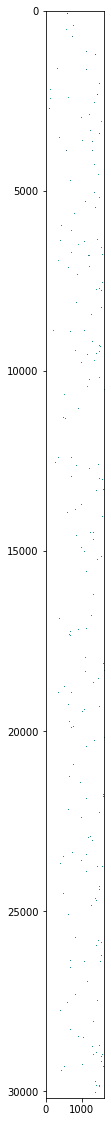

In [18]:
AA = f1_frame.features[0].support.interpolator.AA
AAd = AA.todense()
ATA = AA.T.dot(AA)
ATAd = ATA.todense()
ATAd[ATAd==0] = np.nan
AAd[AAd==0] = np.nan
plt.figure(figsize=(20,20))
plt.imshow(AAd)
# np.savetxt('aad.txt',AAd)

(array([12076., 12072., 12076., 12072., 12072., 12076., 14799., 15095.,
        15090., 14465.]),
 array([    0. ,  3018.4,  6036.8,  9055.2, 12073.6, 15092. , 18110.4,
        21128.8, 24147.2, 27165.6, 30184. ]),
 <a list of 10 Patch objects>)

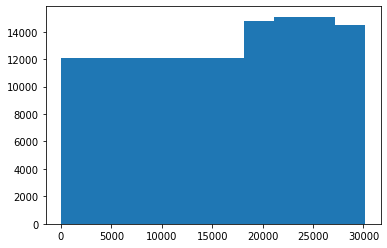

In [19]:
plt.hist(f1_frame.features[0].support.interpolator.row)


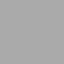

In [20]:
viewer = LavaVuModelViewer(background="white")
viewer.plot_model_box(boundary_points,
                      (100,100,50),
                      's0',
                      paint_with=f1_frame.features[0])
# viewer.plot_isosurface(f1_frame.features[0],
#                        paint_with=f1_frame.features[0],
#                        nslices=10,
# #                        slices=[0,1,5],
# #                        colour='green',
#                       )
# viewer.plot_isosurface(f1_frame.features[1],
# #                        nslices=10,
#                        colour='green')
# viewer.plot_isosurface(f2_frame.features[0])
# viewer.plot_isosurface(f2_frame.features[1],
#                        colour='blue')
# viewer.plot_vector_data(locations,s1g,'s1g')
# viewer.plot_vector_data(locations,FX,'axis')
# viewer.plot_vector_data(locations,R2R,'r2r')
# viewer.plot_vector_data(locations,np.cross(R2R,FX,axisa=1,axisb=1),'folded')
# viewer.plot_vector_data(xyz,s1g,'s0',size=2)
# viewer.plot_vector_data(xyz,l2,'l2',size=2)
# viewer.plot_vector_data(xyz,fold.get_fold_axis_orientation(xyz),'axis',size=2)
# viewer.plot_vector_data(xyz,f2_frame.features[1].evaluate_gradient(xyz),'gy',size=2)
# viewer.plot_vector_data(locations,r2r,'r2r')
viewer.plot_data(f1_frame.features[0])
viewer.interactive()

## Interpolate the folded foliation
The process of building a folded foliation is similar to how the folded fold frame coordinate was build, except we use a GeologicalFeatureInterpolator rather than the StructuralFrameBuilder.

As for before:
1. Initialise a fold event
2. Initialise a fold interpolator
3. Initialise a feature builder with the interpolator and a name
4. Associate data to the feature builder
5. Build with no solver.

In [21]:
f1 = FoldEvent(f1_frame,None,None)
stratigraphy_interpolator = DFI(mesh, f1)
stratigraphy_builder = GeologicalFeatureInterpolator(stratigraphy_interpolator, 
                                                     name="folded_stratigraphy")
for r in data['s0_dir.csv']:
    stratigraphy_builder.add_planar_constraint(r[:3],-r[3:])

strati = stratigraphy_builder.build(cgw=0,solver=None)
# viewer.plot_vector_data(strati.support.interpolator.get_gradient_control()[:,:3],
#                         strati.support.interpolator.get_gradient_control()[:,3:],
#                         "strati_grad2",
#                         colour='green')
#@strati_g = 





Resetting interpolation constraints
Cannot rerun interpolator


Calculate the S-Plot and S-Variogram in the same way

Text(0.5, 1.0, 'Fold axis rotation angle S-Variogram')

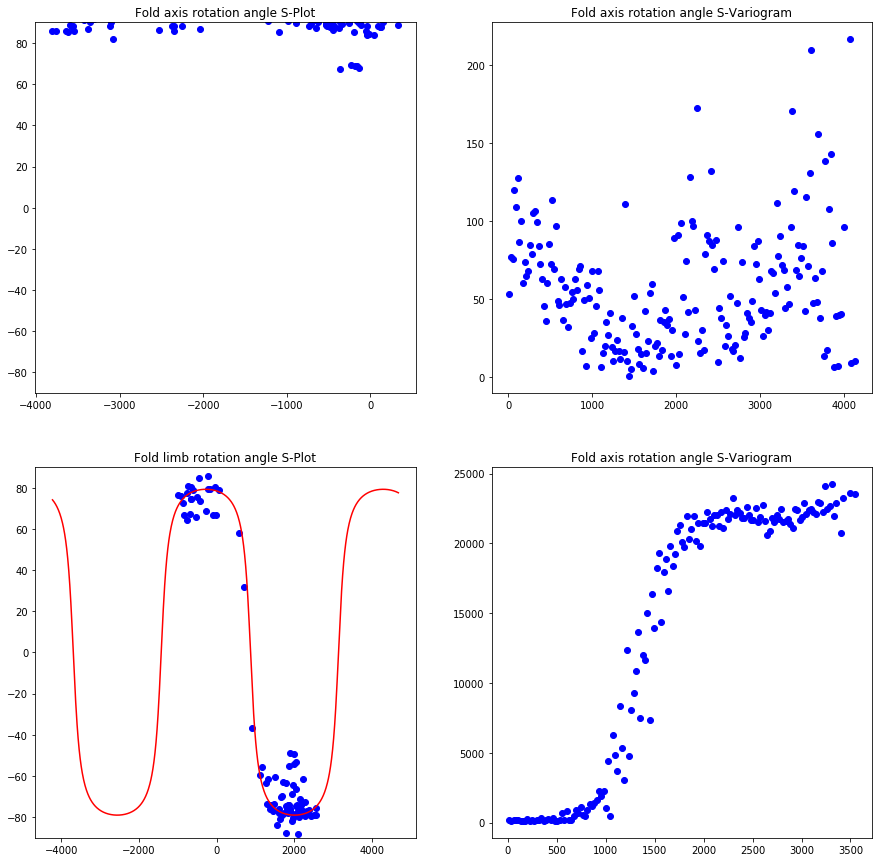

In [22]:

l1 = f1_frame.calculate_intersection_lineation(
    strati.support.interpolator.get_gradient_control())
far = f1_frame.calculate_fold_axis_rotation(
    strati.support.interpolator.get_gradient_control())
s1 = f1_frame.features[0].evaluate_value(
    strati.support.interpolator.get_gradient_control()[:,:3])
s1gy = f1_frame.features[1].evaluate_value(
    strati.support.interpolator.get_gradient_control()[:,:3])
axis_svariogram = SVariogram(s1gy,far)
axis_svariogram.calc_semivariogram()

far_tan = np.tan(np.deg2rad(far))
xi = np.linspace(f1_frame.features[1].min(),
                 f1_frame.features[1].max(), 1000)
f1.fold_axis = np.mean(l1,axis=0)#np.array([-0.00597993,  0.70559948, -0.70858565])
axis = f1.get_fold_axis_orientation( 
    strati.support.interpolator.get_gradient_control()[:,:3])
flr = f1_frame.calculate_fold_limb_rotation(
    strati.support.interpolator.get_gradient_control()
                                            ,axis=axis)
limb_svariogram = SVariogram(s1,flr)
limb_svariogram.calc_semivariogram()

flr_tan = np.tan(np.deg2rad(flr))

guess = np.zeros(4)
guess[3] = 4000
popt, pcov = curve_fit(fourier_series,s1,flr_tan,guess)

xi = np.linspace(f1_frame.features[0].min(),f1_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))

# flr = fold_rotation_angle_feature(f2_frame,fold_limb_rotation)
f1.fold_limb_rotation = fold_limb_rotation
# f1_limb_feature = fold_rotation_angle_feature(f1_frame,fold_limb_rotation)
rotation_plots = RotationAnglePlotter()
rotation_plots.add_fold_axis_data(far,s1gy)
rotation_plots.add_axis_svariogram(axis_svariogram)
# rotation_plots.add_fold_axis_curve(fold.fold_axis_rotation(xi),xi)
rotation_plots.add_fold_limb_data(flr,s1)
rotation_plots.add_limb_svariogram(limb_svariogram)
rotation_plots.add_fold_limb_curve(fold.fold_limb_rotation(xi), xi)
rotation_plots.ax[0][0].set_title("Fold axis rotation angle S-Plot")
rotation_plots.ax[0][1].set_title("Fold axis rotation angle S-Variogram")
rotation_plots.ax[1][0].set_title("Fold limb rotation angle S-Plot")
rotation_plots.ax[1][1].set_title("Fold axis rotation angle S-Variogram")


In [23]:
fold_weights = {}
fold_weights['fold_orientation'] = 10. # reference values?
fold_weights['fold_axis'] = 10. # reference values?
fold_weights['fold_normalisation'] = 1.0#10. # reference values?
fold_weights['fold_regularisation'] = .10
# stratigraphy_builder.interpolator.p_g = []
stratigraphy_builder.interpolator.n_g = len(stratigraphy_builder.interpolator.p_g)
folded_stratigraphy = stratigraphy_builder.build(solver='lu',
                                                 cgw=0,
                                                 fold_weights=fold_weights,
                                                 fold=f1)

Resetting interpolation constraints
6134



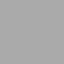

In [24]:
viewer = LavaVuModelViewer(background="white")
viewer.plot_model_box(boundary_points,
                      (100,100,50),
                      's0',
                      cmap='tab20',
                      paint_with=folded_stratigraphy)
# viewer.plot_isosurface(f1_frame.features[0],
#                        slices=[0.37,0.6,0.82],
# #                        nslices=5,
#                        colour='green')
# viewer.plot_isosurface(f1_frame.features[1],
# #                        nslices=10,
#                        colour='green')
# viewer.plot_isosurface(folded_stratigraphy,
#                        nslices=5,
#                        colour='blue')
# viewer.plot_isosurface(f2_frame.features[0])
# viewer.plot_isosurface(f2_frame.features[1],
#                        colour='blue')
# viewer.plot_vector_data(xyz,f1.get_fold_axis_orientation(xyz),'axis')
# viewer.plot_vector_data(locations,s1g,'s1g')
# viewer.plot_vector_data(locations,FX,'axis')
# viewer.plot_vector_data(locations,R2R,'r2r')
# viewer.plot_vector_data(locations,np.cross(R2R,FX,axisa=1,axisb=1),'folded')
# viewer.plot_vector_data(xyz,s0g,'s0',size=2)
viewer.interactive()

In [25]:
viewer.lv.image("refolded_folds.jpg")

'refolded_folds.jpg'